## **Class Activation Maps (CAM) and Saliency Maps are techniques used to visualize and understand the important regions of an input image that contribute to the prediction of a neural network, especially Convolutional Neural Networks (CNNs).**


* ### CAM produces a heatmap that highlights discriminative regions of an image related to a specific class by associating importance weights with different spatial locations in the image. It weights the feature maps based on the importance values and produces a weighted combination.


Conclusões:
04/02 - o tamanho das layers intermedias e muito pequeno e faz com que o gradcam apanhe imensa area da imagem. Considerar mudar para um arquitectura maior em que as layers intermedias tambem sao maiores 

In [1]:
import sys
sys.path.append("..")

In [ ]:
# !pip install torch torchvision
# !pip install scikit-learn
# !pip install pillow
# !pip install pandas
# !pip install seaborn
# !pip install opencv-python 
# !pip install matplotlib
# !pip install pytorch-lightning
# !pip install scikit-image


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, log_loss, jaccard_score)
import numpy as np
import os
from PIL import Image
from shutil import copyfile  
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt

# **Model checkpoint**

In [3]:
import os
from pathlib import Path

BASE_DIR = '/nas-ctm01/homes/dpmoura/CV_final_proj'
DATA_DIR = '/nas-ctm01/homes/dpmoura/xai-post-hoc/cifar-10-batches-py'
BATCH_SIZE = 128

# **Accuracy and loss graph of training and validation**

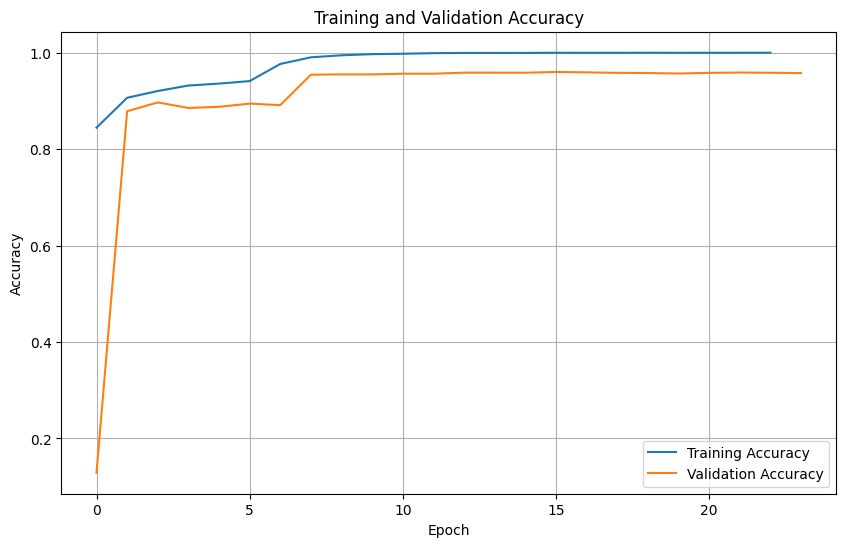

Saved training curves to training_metrics.png


In [4]:
from plotting import plot_training_curves

train_metrics_path = BASE_DIR + '/models/logs/version_3/training_metrics.npz'  

plot_training_curves(metrics_path= train_metrics_path, output_path = 'training_metrics.png') 

# **Testing**

Neste momento tou a guardar no server nao preciso de testar

In [5]:
# Define the path
test_results_path = BASE_DIR + '/models/logs/version_3/test_results.npz'

# Load the .npz file
test_results = np.load(test_results_path)

# Extract data
test_preds = test_results['preds']
test_targets = test_results['targets']
test_probs = test_results['probs']


In [6]:
test_results.files

['probs', 'preds', 'targets']

# **Classification Report**

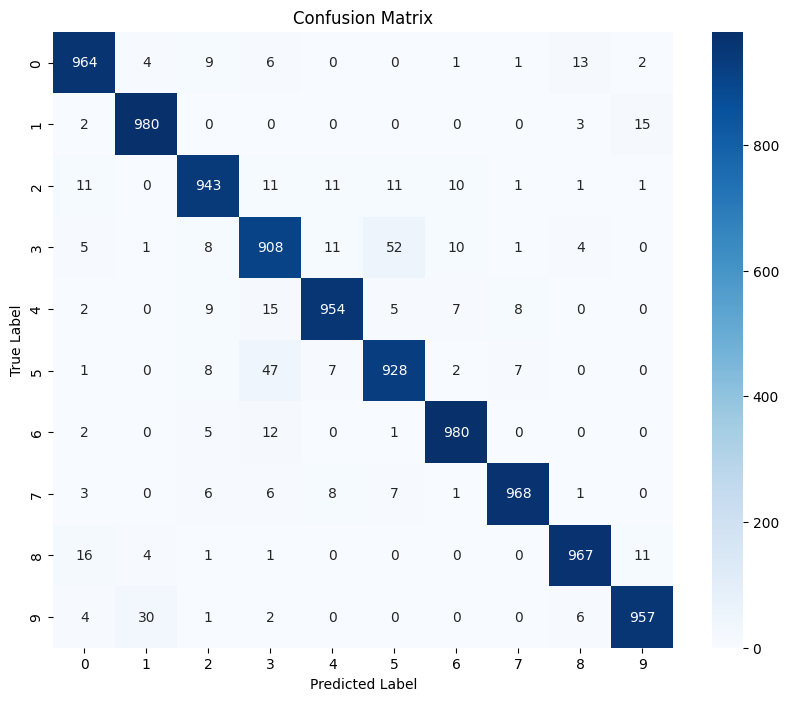

Saved classification report to classification_report.txt
Saved confusion matrix to confusion_matrix.png
Classification Report:
None
Final Test Accuracy: 95.49%


In [7]:
from reporting import generate_classification_report

report = generate_classification_report(test_targets, test_preds)
print("Classification Report:")
print(report)

# 4. Get final metrics from logged results
accuracy = (test_preds == test_targets).mean()
print(f"Final Test Accuracy: {accuracy:.2%}")

# **No. 1 : Explainable AI (GradCAM)**

Proximo passo é mudar esta funcao para sacar uma imagem de cada classe como so ha duas e gerar diferentes metodos

In [8]:

checkpoint_path = BASE_DIR + '/models/checkpoints' 

import os
if os.path.exists(checkpoint_path):
    print(f"Path exists: {checkpoint_path}")
    print("Contents:", os.listdir(checkpoint_path))
else:
    print("Path does not exist.")


# try:
#     checkpoint = torch.load(checkpoint_path, map_location="cpu", pickle_module=pickle)
#     print("Checkpoint loaded successfully!")
# except Exception as e:
#     print("Error loading checkpoint:", e)

Path exists: /nas-ctm01/homes/dpmoura/CV_final_proj/models/checkpoints
Contents: ['best_model.ckpt', 'best_model-v1.ckpt', 'best_model-v2.ckpt', 'best_model-v3.ckpt']


In [9]:
import gc
import torch

# List all loaded PyTorch models
for obj in gc.get_objects():
    if isinstance(obj, torch.nn.Module):
        print(type(obj))  # Print the model class name


/tmp/ipykernel_3243919/231653710.py:6: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if isinstance(obj, torch.nn.Module):


In [10]:
model_path = checkpoint_path + '/best_model-v3.ckpt'

In [11]:
try:
    checkpoint = torch.load(model_path, weights_only=True, map_location="cpu")  
    print("Checkpoint loaded successfully!")
except Exception as e:
    print("Error loading checkpoint:", e)


Checkpoint loaded successfully!


In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from skimage.transform import resize

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

from lit_model import LitResNet
from data_module import CIFAR10DataModule

model = LitResNet.load_from_checkpoint(model_path)
model.eval()

dm = CIFAR10DataModule(data_path=DATA_DIR, batch_size=BATCH_SIZE)
dm.prepare_data()
dm.setup("fit")
test_loader = dm.test_dataloader()

# De-normalization
def denormalize_cifar(img_tensor):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    return img_tensor * std + mean

# # Load one sample
# dm = CIFAR10DataModule(data_path=DATA_DIR, batch_size=1)
# dm.prepare_data()
# dm.setup("fit")
# img_tensor, label = next(iter(dm.test_dataloader()))

# # Format and visualize
# img = denormalize_cifar(img_tensor[0])  # remove batch dim
# img_np = img.numpy().transpose(1, 2, 0)
# img_np = np.clip(img_np, 0, 1)

# plt.figure(figsize=(4, 4))  # Optional: upscale figure
# plt.imshow(img_np, interpolation='nearest')
# plt.title(f"Label: {label.item()}")
# plt.axis("off")
# plt.show()


In [13]:
print(model)


LitResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          


METHOD: GRADCAM


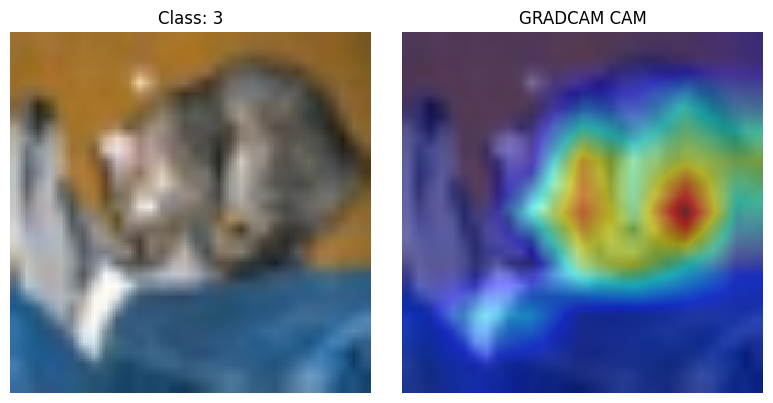

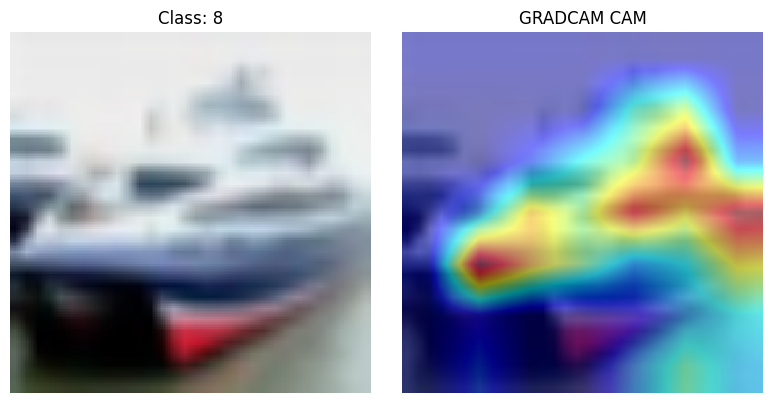

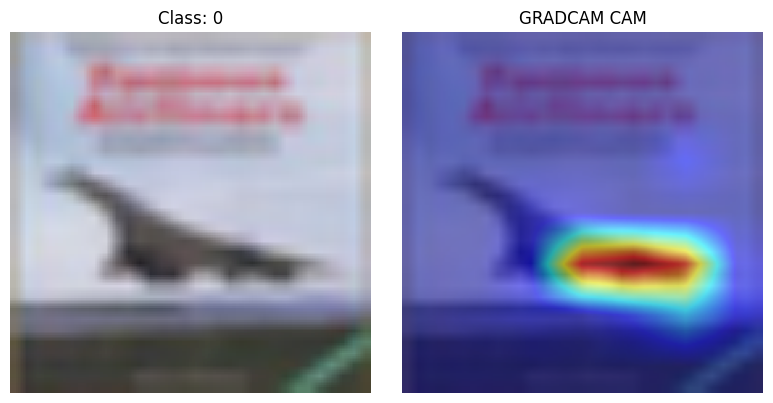

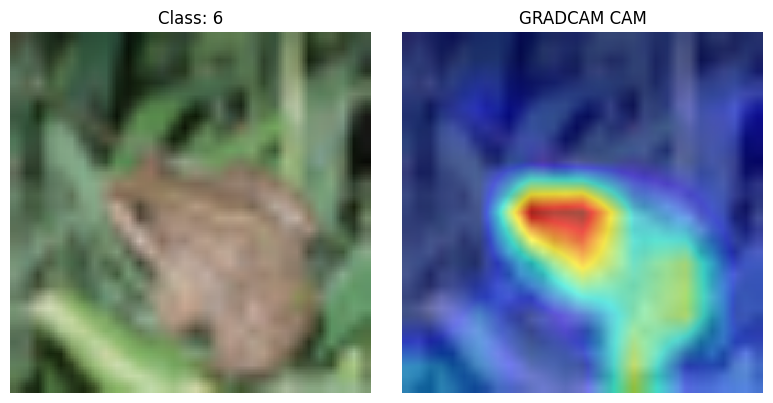

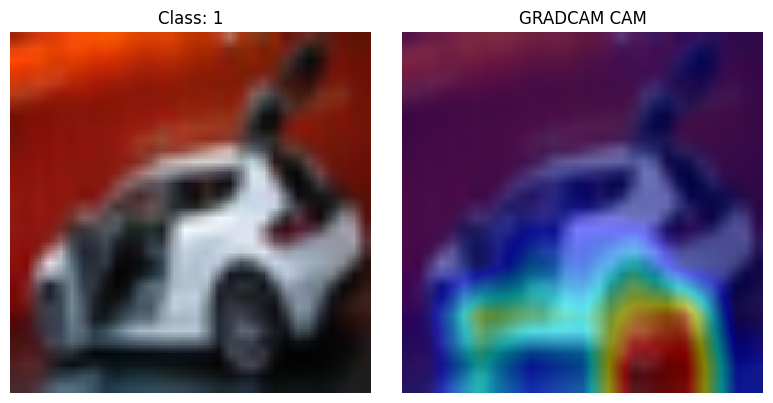

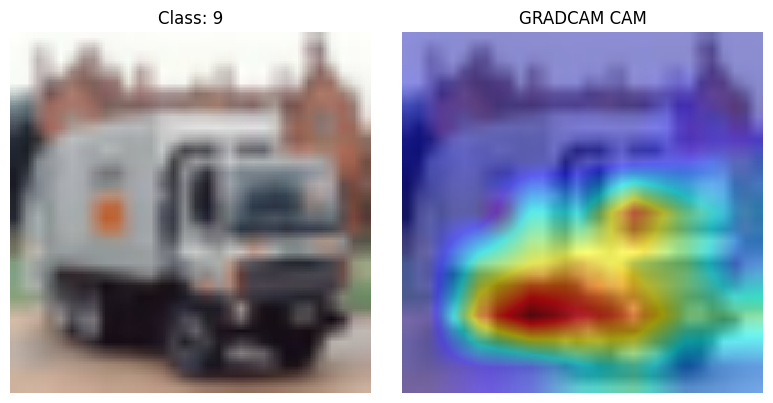

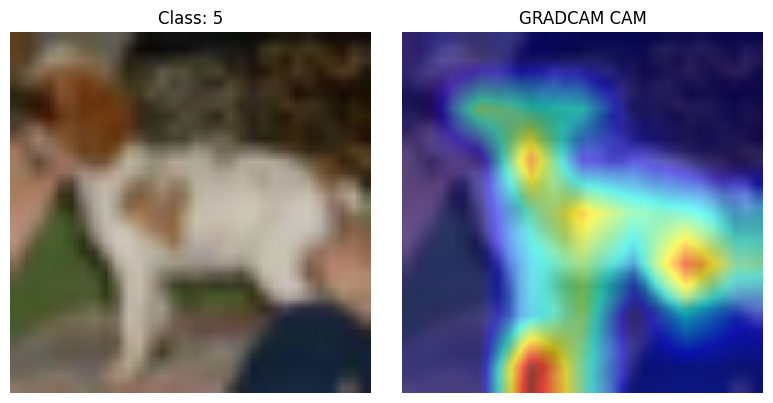

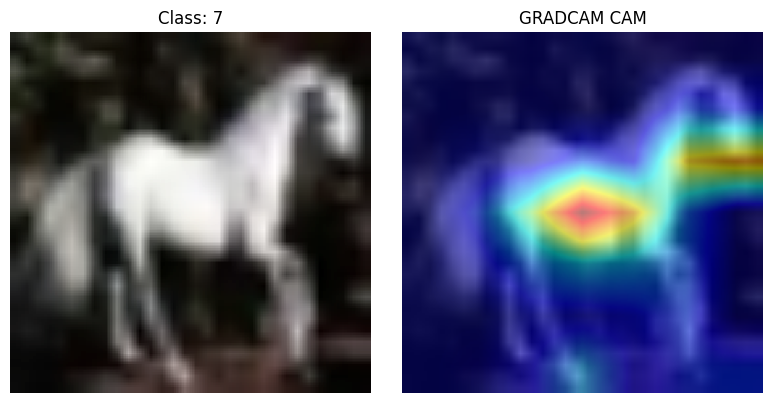

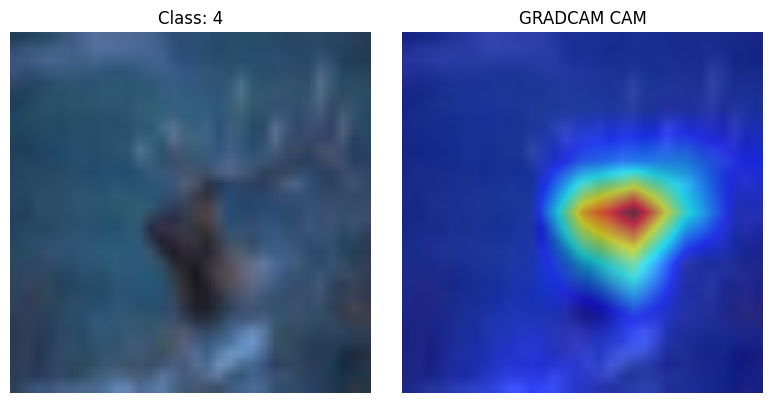

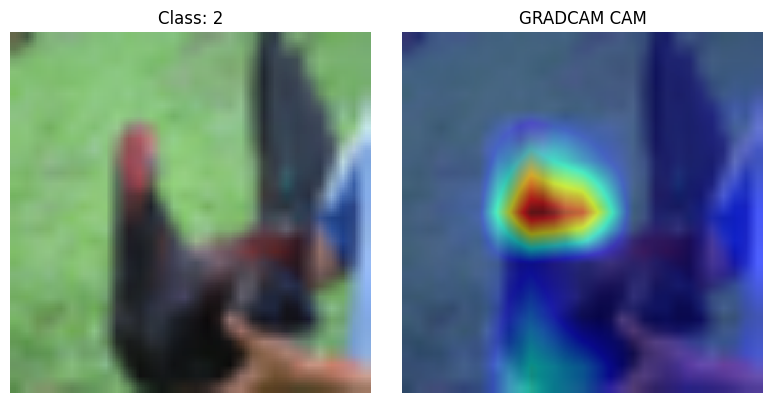


METHOD: HIRESCAM


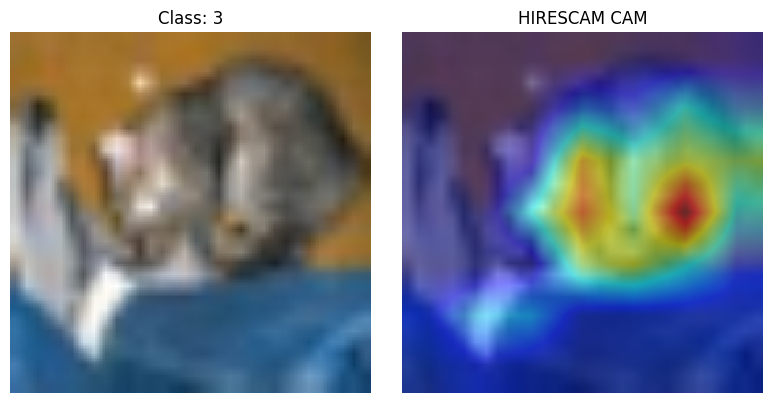

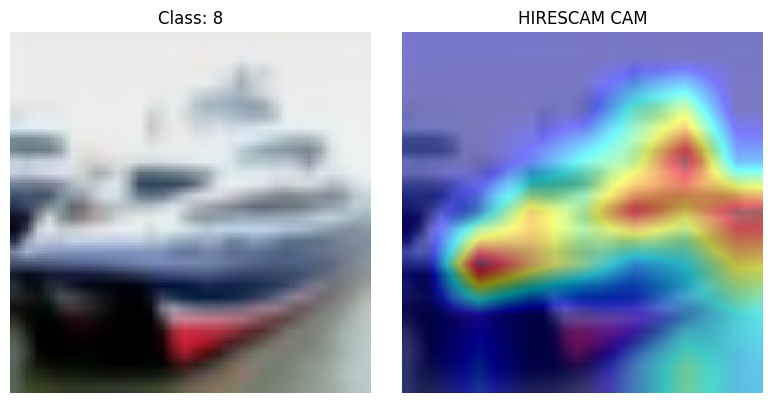

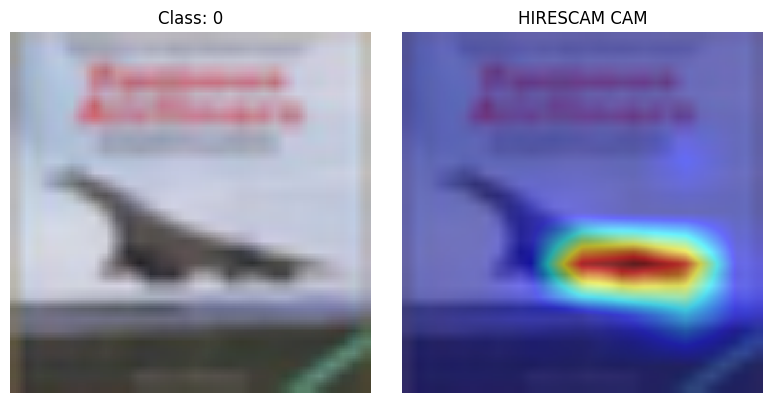

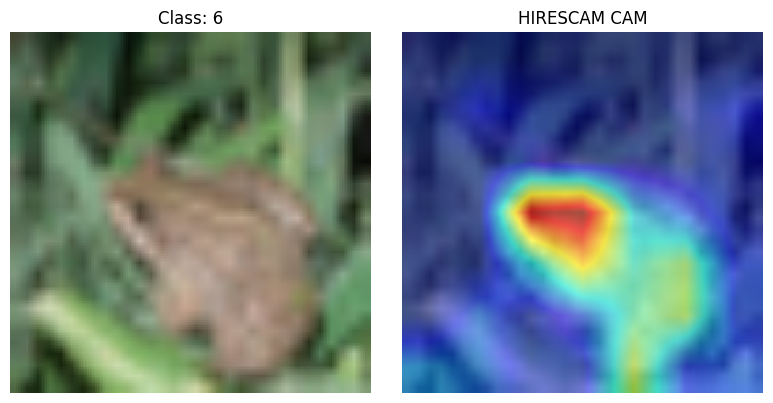

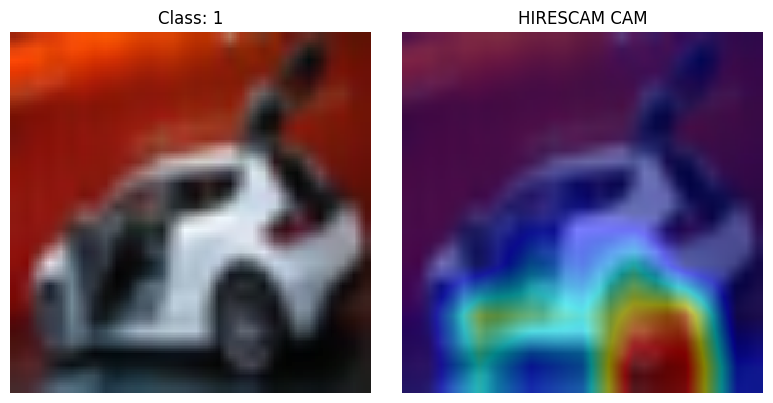

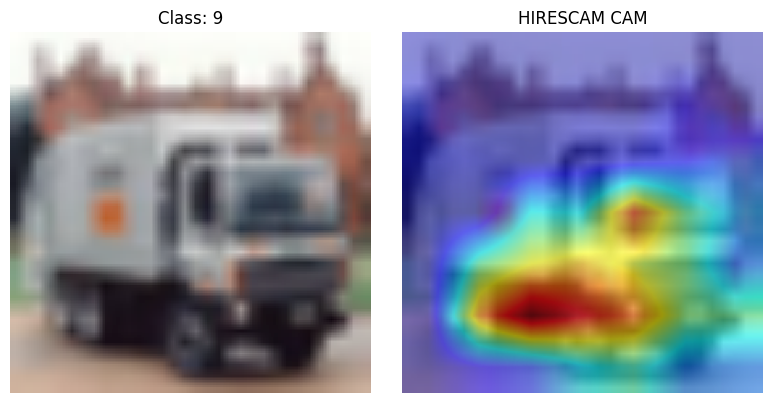

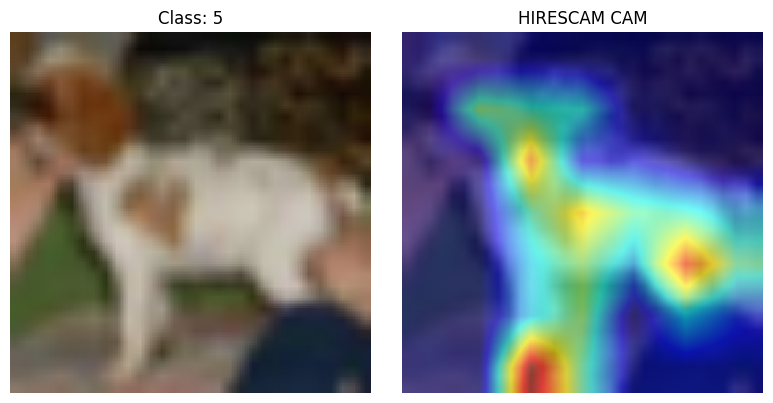

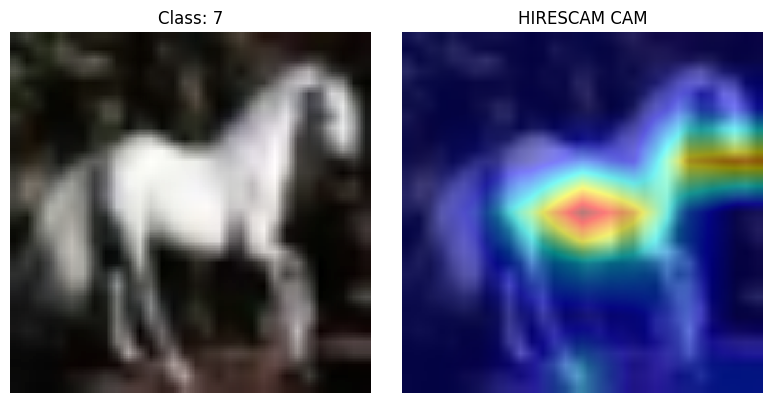

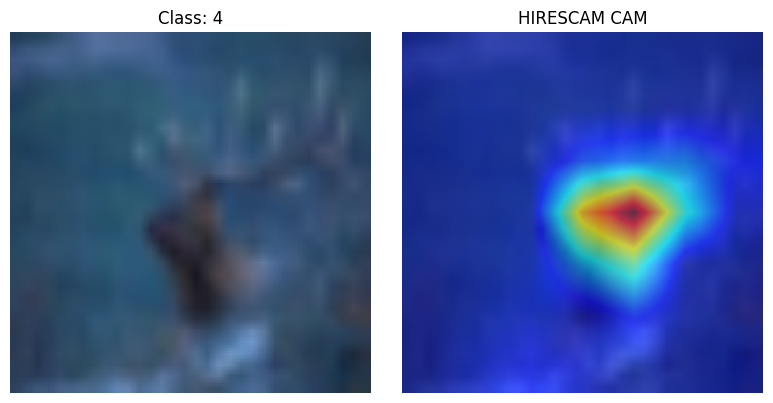

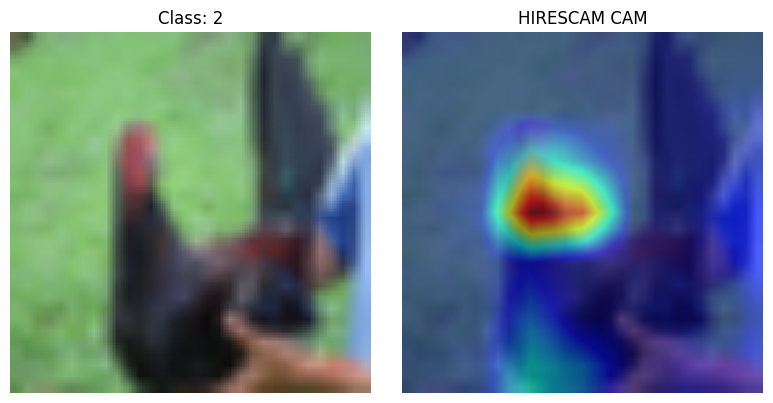


METHOD: SCORECAM


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:27<00:00,  1.46it/s]


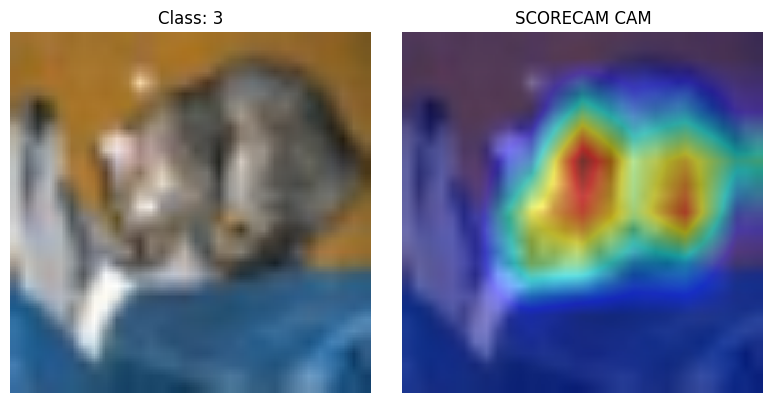

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:25<00:00,  1.50it/s]


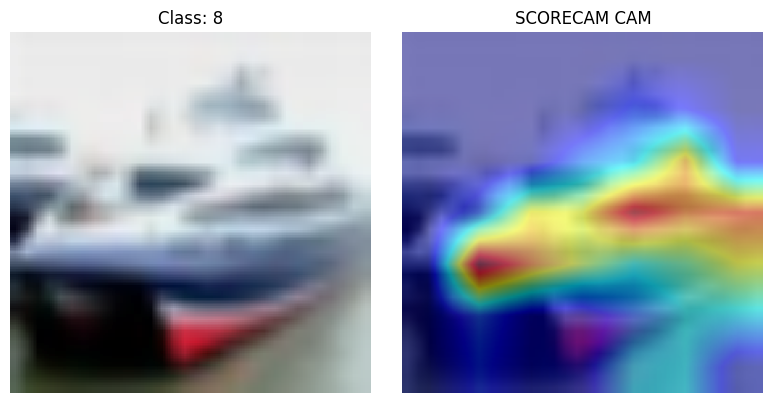

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:28<00:00,  1.44it/s]


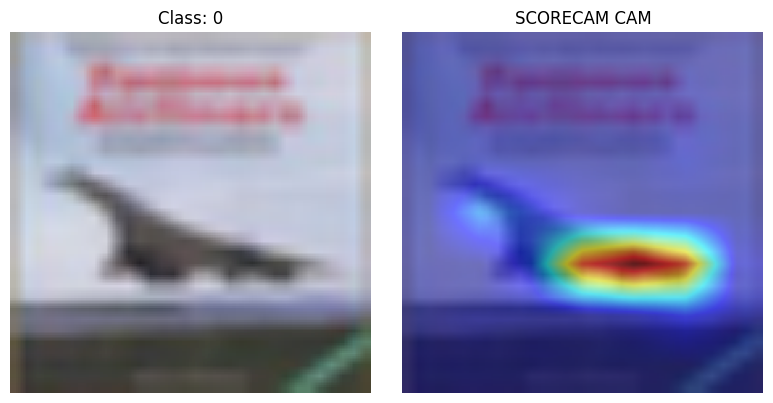

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:31<00:00,  1.40it/s]


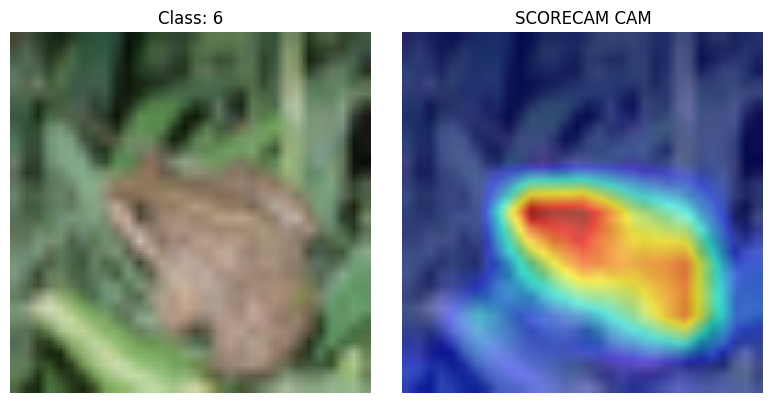

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:28<00:00,  1.45it/s]


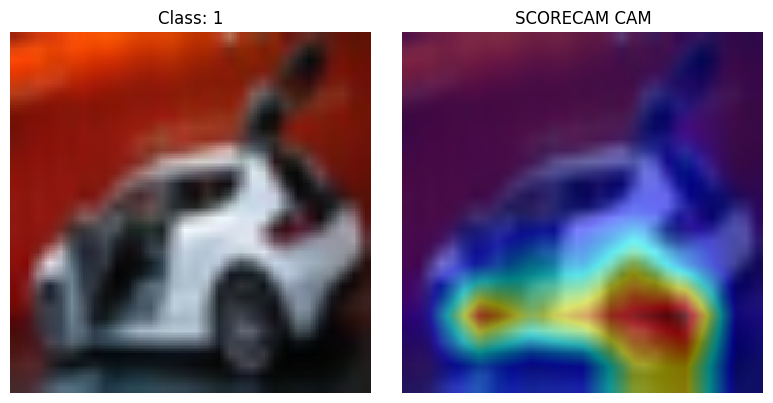

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:18<00:00,  1.63it/s]


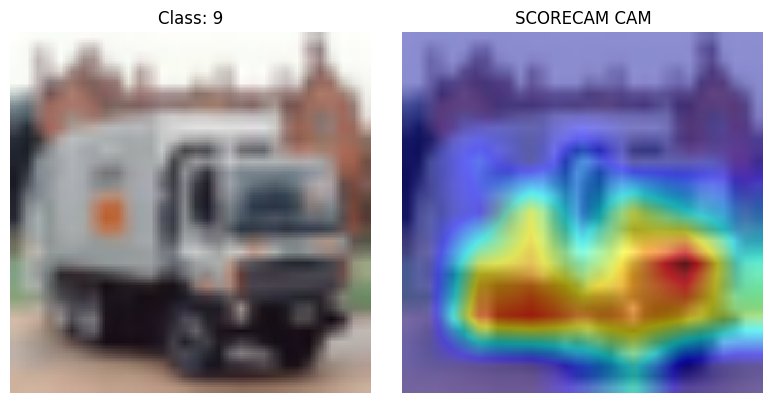

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:26<00:00,  1.47it/s]


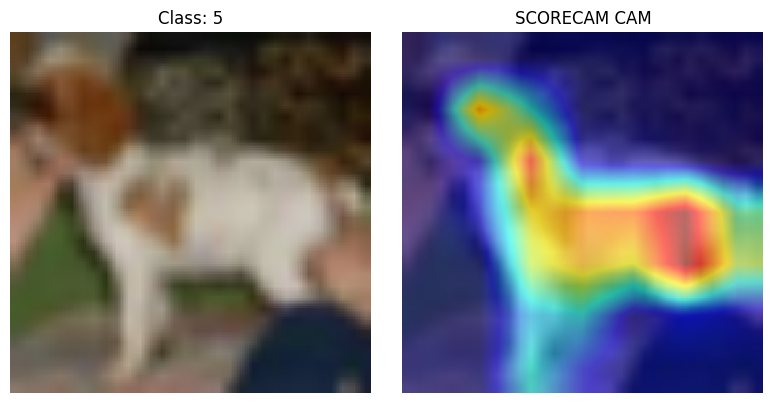

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [01:37<00:00,  1.31it/s]


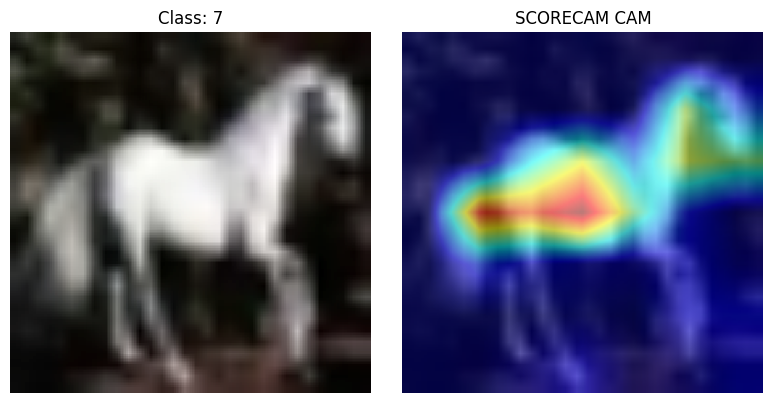

 88%|████████████████████████████████████▏    | 113/128 [01:23<00:14,  1.03it/s]

In [ ]:
import torch
import numpy as np
from pytorch_grad_cam import (
    GradCAM, HiResCAM, ScoreCAM
)
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from skimage.transform import resize
import matplotlib.pyplot as plt
from collections import defaultdict

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_IMAGES_PER_CLASS = 1

# Target CAM layer
target_layers = [model.model.layer4[-1]]

# Collect 2 correct examples per class
class_to_samples = defaultdict(list)

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1)

    for i in range(images.size(0)):
        true_class = labels[i].item()
        pred_class = preds[i].item()
        if true_class == pred_class and len(class_to_samples[true_class]) < NUM_IMAGES_PER_CLASS:
            class_to_samples[true_class].append((images[i].detach().cpu(), pred_class))

    if all(len(class_to_samples[c]) >= NUM_IMAGES_PER_CLASS for c in range(10)):
        break

# Supported CAM methods
CAM_METHODS = {
    "gradcam": GradCAM,
     "hirescam": HiResCAM,
     "scorecam": ScoreCAM
}


# Apply each method
for method_name, cam_method in CAM_METHODS.items():
    print(f"\nMETHOD: {method_name.upper()}")
    
    with cam_method(model=model, target_layers=target_layers) as cam:
        for class_id, samples in class_to_samples.items():
            for img_tensor, pred_class in samples:
                input_tensor = img_tensor.unsqueeze(0).to(device)

                # Set the target class for GradCAM
                targets = [ClassifierOutputTarget(pred_class)]

                # Run GradCAM and get the grayscale map
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

                # De-normalize image
                img_tensor_denorm = denormalize_cifar(img_tensor)
                img_np = img_tensor_denorm.numpy().transpose(1, 2, 0)
                img_np = np.clip(img_np, 0, 1)

                # Overlay CAM on image (no manual resizing needed)
                visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

                # Plot
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(img_np, interpolation='nearest')
                plt.title(f"Class: {class_id}")
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.imshow(visualization)
                plt.title(f"{method_name.upper()} CAM")
                plt.axis("off")

                plt.tight_layout()
                plt.show()